# Importing Packages and Reading the Data

In [24]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widget 

In [25]:
twitter = pd.read_csv('twitter.csv')
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14262517 entries, 0 to 14262516
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   longitude  float64
 1   latitude   float64
 2   timestamp  int64  
 3   timezone   int64  
dtypes: float64(2), int64(2)
memory usage: 435.3 MB


# An Overview: 5 Columns – Longitude, Latitude, Timestamp, and Timezone.

In [26]:
print(twitter.head(5),"\n\n",twitter.tail(5))

   longitude   latitude       timestamp  timezone
0 -87.895450  43.063007  20130112000000         2
1 -93.674799  45.025114  20130112000000         2
2 -97.104568  32.709685  20130112000000         2
3 -71.120095  42.351453  20130112000000         1
4 -79.048690  43.100826  20130112000000         1 

            longitude   latitude       timestamp  timezone
14262512  -90.703468  42.495940  20130118235955         2
14262513  -80.084576  37.292336  20130118235955         1
14262514  -81.509412  41.574817  20130118235955         1
14262515  -98.181743  26.202471  20130118235955         2
14262516 -122.308808  47.563866  20130118235955         4


# Some Elementary Transformations for Exploration.

In [27]:
twitter.sort_values(by=["timestamp"])
twitter["timestamp"] = pd.to_datetime(twitter["timestamp"],format='%Y%m%d%H%M%S')
twitter["date"] = twitter["timestamp"].dt.date
twitter["time"] = twitter["timestamp"].dt.time

day_date = [str(i.year)+"-"+str(i.month)+"-"+str(i.day) for i in pd.Series(twitter["date"].unique()).tolist()]

# Graphic's Too Dense for a Reasonable Visualization.

In [28]:
from datetime import date

slider = widget.SelectionSlider(options = day_date, description="Select Date:")

def loc_plot(day_date):
    year, month, day = map(int, day_date.split("-"))
    twitter2 = twitter[twitter["date"]==date(year,month,day)]
    twitter2.plot(kind="scatter", x="longitude", y="latitude",alpha=0.1)

widget.interactive(loc_plot,day_date = slider)

interactive(children=(SelectionSlider(description='Select Date:', options=('2013-1-12', '2013-1-13', '2013-1-1…

# Let's Simplify Things a Bit.

In [29]:
twitter3 = twitter

twitter3["long"]=twitter3["longitude"].apply(lambda x: int(str(x).partition(".")[0]))
twitter3["lat"]=twitter3["latitude"].apply(lambda x: int(str(x).partition(".")[0]))

twitter3_pivot = twitter3.groupby(by=["date", "long", "lat"])["timestamp"].count()
twitter3_pivot.to_frame()
indices = twitter3_pivot.index.to_list()
indices_date_time = [i[0] for i in indices]
indices_long = [i[1] for i in indices]
indices_lat = [i[2] for i in indices]

values=twitter3_pivot.values.tolist()

twitter_aggregate = pd.DataFrame(data = zip(indices_date_time,indices_long,indices_lat,values), 
                                 index=[i for i in range(0,len(values))], 
                                 columns=["daydate","long","lat","Tweet Count"])

# A Few Basic Observations: 
1. Eastern U.S. has a higher volume of tweets compared to other regions.
2. Metropolitan areas have a higher volume of tweets.

In [ ]:
def loc_plot2(day_date):
    year, month, day = map(int, day_date.split("-"))
    twitter_aggregate2=twitter_aggregate[twitter_aggregate["daydate"]==date(year,month,day)]
    twitter_aggregate2.plot(figsize=(8,4), kind="scatter",x="long",y="lat",c="Tweet Count",
                            alpha=0.2,colorbar=True,colormap="jet",
                            s=twitter_aggregate2["Tweet Count"]*0.01,
                            xlabel="Longitude", ylabel="Latitude")

widget.interactive(loc_plot2,day_date = slider)

interactive(children=(SelectionSlider(description='Select Date:', options=('2013-1-12', '2013-1-13', '2013-1-1…

# Eastern US Has More Tweets!

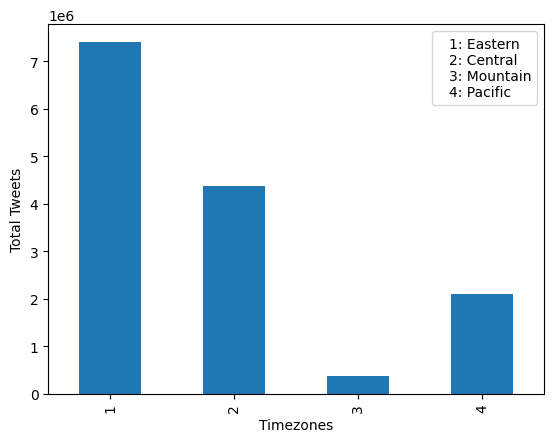

In [31]:
import matplotlib.pyplot as plt

twitter_time_zoned = twitter.pivot_table(index=["timezone"],aggfunc={"timestamp":"count"})

twitter_time_zoned.plot(kind="bar", legend=True, 
                        xlabel="Timezones", ylabel="Total Tweets").legend(["1: Eastern\n2: Central\n3: Mountain\n4: Pacific"], 
                        loc="upper right",markerscale=0, handlelength=0)

# Is There a Statistically Significant Difference in the Mean Tweet Count Across Days?

In [32]:
daydate_list = twitter_aggregate["daydate"].unique().tolist()

count_by_date={}

for i in daydate_list:
    data_frame=twitter_aggregate[twitter_aggregate['daydate']==i]
    day_date_str = pd.to_datetime(str(i)).strftime("%Y-%m-%d")
    count_by_date[day_date_str]=data_frame
    

# From the Rough Visual, We’d Expect No Significant Difference in Means—But Those Periodic Spikes Might Be Worth Unpacking Later. Highly Overdispersed Poisson Distributions Likely Due to Trending Cycles.

Dispersion ≈ 12542.05


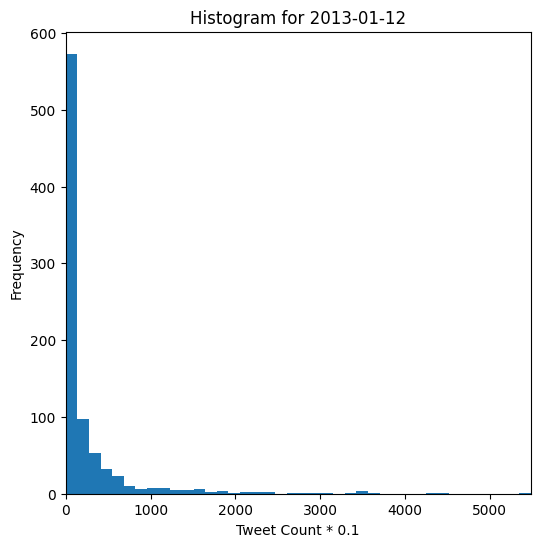

Dispersion ≈ 13530.85


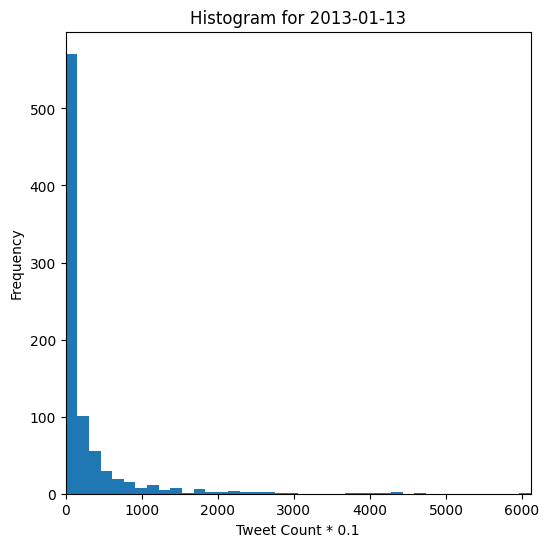

Dispersion ≈ 11733.62


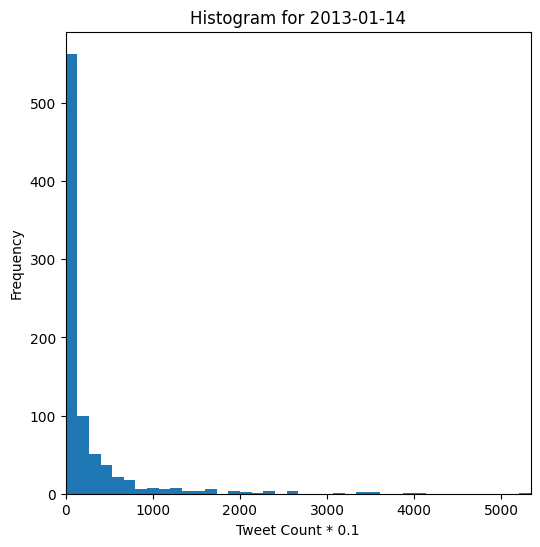

Dispersion ≈ 11744.81


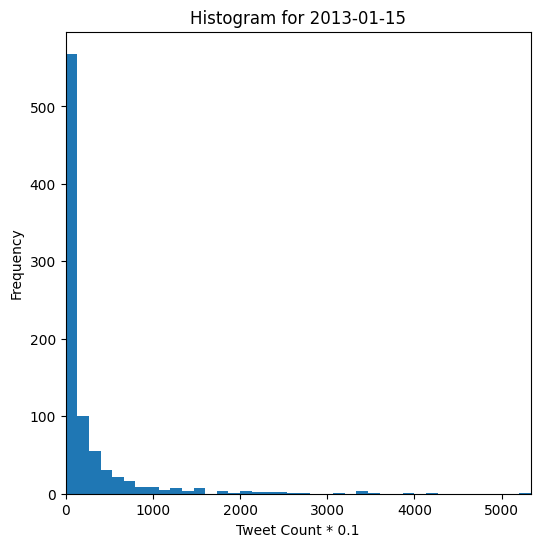

Dispersion ≈ 12159.19


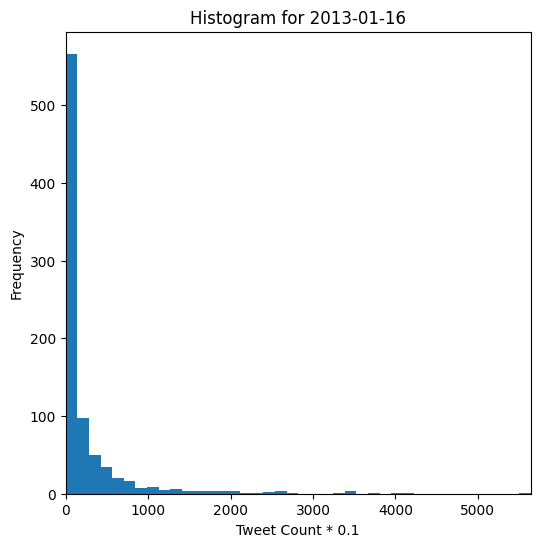

Dispersion ≈ 11649.12


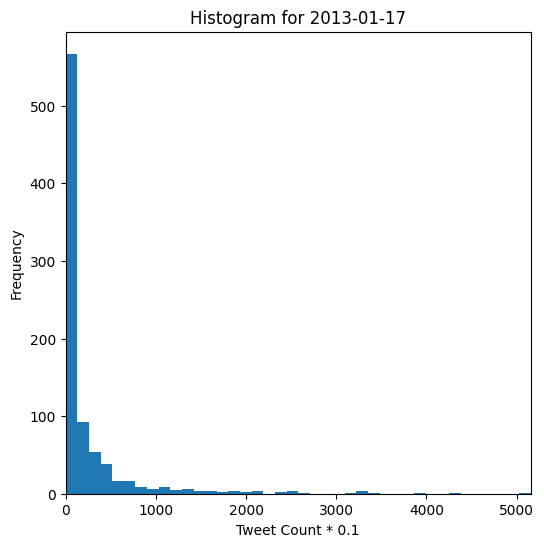

Dispersion ≈ 11537.09


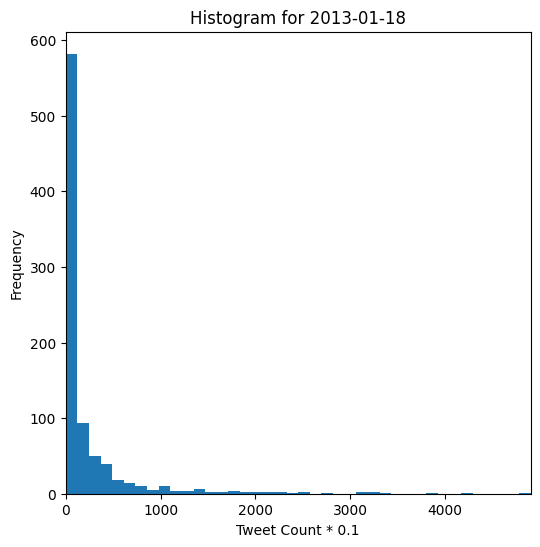

In [33]:
tweet_count_groups = []

for i in count_by_date:
    var = pd.to_datetime(str(i)).strftime("%Y-%m-%d")
    var2 = count_by_date[var]["Tweet Count"]
    tweet_count_groups.append(var2)
    
    plt.figure(figsize=(6,6))
    (var2*0.1).plot(kind="hist", bins=40)
    plt.title(f"Histogram for {var}")
    plt.xlabel("Tweet Count * 0.1")
    plt.ylabel("Frequency")

    plt.xlim(0,max(var2*0.1))

    print(f"Dispersion ≈ {round(np.var(var2)/np.mean(var2),2)}")
    
    plt.show()  




In [34]:
from sklearn.utils import resample

arr_sizes = []

for i in tweet_count_groups:
    arr_sizes.append(len(i))

min_sample = np.max(arr_sizes)

tweet_count_groups_resampled=[]

for i in count_by_date:
    var = pd.to_datetime(str(i)).strftime("%Y-%m-%d")
    var2 = count_by_date[var]["Tweet Count"]
    var3 = resample(var2, n_samples=min_sample, random_state=42)
    tweet_count_groups_resampled.append(var3)

# Visual Inspection Indicated Similarity, Confirmed With Kruskal—Overdispersion Is Unreasonable for Poisson.

In [35]:
from scipy.stats import kruskal

statistic, p_value = kruskal(*tweet_count_groups_resampled)

print(f"Kruskal-Wallis statistic: {statistic:.3f}")
print(f"P-value: {p_value:.3f}")

Kruskal-Wallis statistic: 7.730
P-value: 0.259


# Random Forest Model – Untuned
Can we get a reasonable model?

In [36]:
from sklearn.model_selection import train_test_split

features = twitter_aggregate.drop(columns=["Tweet Count","daydate"])
target = twitter_aggregate["Tweet Count"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, 
                                                    shuffle=False, random_state=42) 


In [37]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=500,max_depth=15)

rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)

# How Does Our Untuned Model Look?

In [38]:
from sklearn.metrics import mean_squared_error
import numpy as np

mean_tweets = twitter_aggregate["Tweet Count"].mean()
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

print(f"Mean Tweets: {mean_tweets}")
print(f"RMSE : {rmse}")

percent_diff = (rmse/mean_tweets)*100
print(f"Percent Difference: {percent_diff:.2f}%")


Mean Tweets: 2391.434775318578
RMSE : 569.4749112953846
Percent Difference: 23.81%


***Some parameter values have been removed due to compute limitations.***

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


rfr = RandomForestRegressor()


param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [100, 250],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
}

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid,
                           cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'max_depth': 250, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
Best Score: -172.2120408377207


# How Does the Tuned Model Perform?

In [40]:
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np

mean_tweets = twitter_aggregate["Tweet Count"].mean()
rmse = np.sqrt(mean_squared_error(y_test,y_pred_tuned))

print(f"mean tweets: {mean_tweets}")
print(f"rmse : {rmse}")

percent_diff = (rmse/mean_tweets)*100
print(f"Percent Difference: {percent_diff:.2f}%")


mean tweets: 2391.434775318578
rmse : 567.4455868628156
Percent Difference: 23.73%


# MAE or RMSE, Can We Do Better?

Our dataset has some limitations due to a handful of outliers, which will inevitably affect our RMSE. However, MAE is a more suitable metric for our case. If we aim to explore and model these outliers effectively, we’ll need more granular data—such as portions of the text or contextual insights related to the days they occur, including trends, sports events, etc. Given these considerations, I believe MAE is the better choice for our model selection.

# MAE and Spread for Our Untuned Model

In [42]:
errors = y_test - y_pred

std_error = np.std(errors)
mean_absolute_error = np.mean(np.abs(errors))

print(f"Standard Deviation of Errors: {std_error}")
print(f"Mean Absolute Error: {mean_absolute_error}")

Standard Deviation of Errors: 543.9100387365072
Mean Absolute Error: 262.9020666115397


# MAE and Spread for Our Tuned Model

In [43]:
errors = y_test - y_pred_tuned

std_error = np.std(errors)
mean_absolute_error = np.mean(np.abs(errors))

print(f"Standard Deviation of Errors: {std_error}")
print(f"Mean Absolute Error: {mean_absolute_error}")

Standard Deviation of Errors: 542.3233750217531
Mean Absolute Error: 260.59165655902484


# Difference?
A marginal imporovement over our untunded model - wide spread for both. We can go with either.

# Train, Test and Predictions Plotted for Comparison
Our tuned model shows slight overfitting, so I’d prefer to go with the untuned model for better generalization.

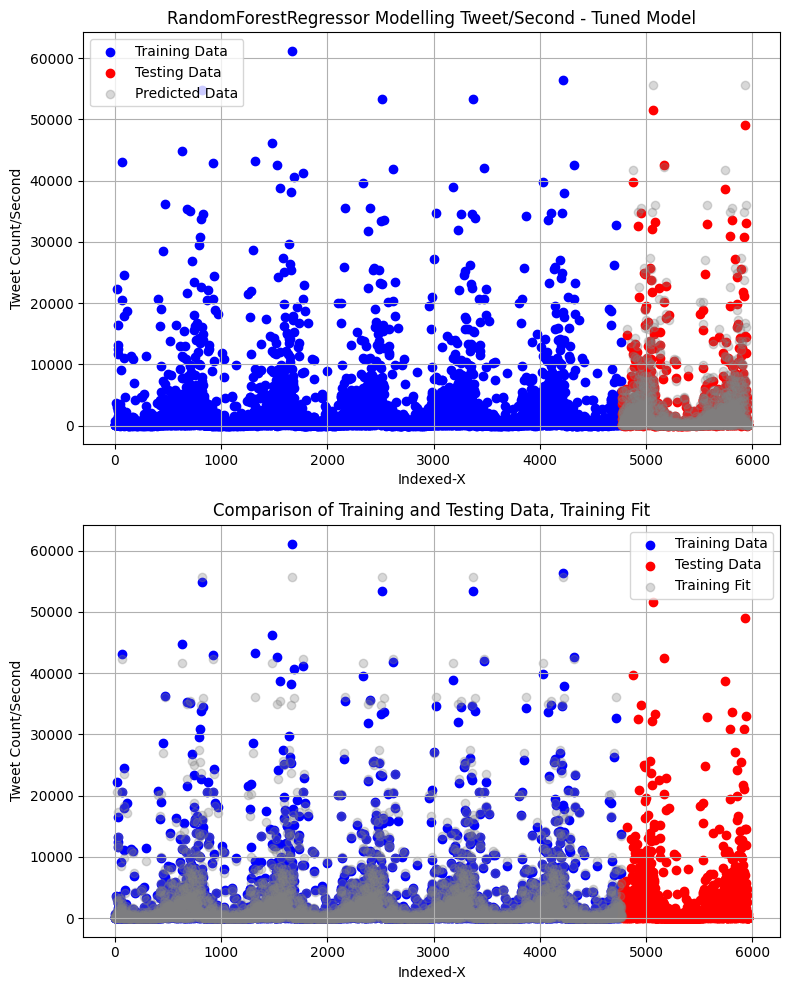

In [44]:
import matplotlib.pyplot as plt

index = twitter_aggregate.index
train_index = index[:len(y_train)]
test_index = index[len(y_train):]

fig, ax = plt.subplots(2, 1, figsize=(8, 10))


ax[0].scatter(train_index, y_train, label="Training Data", color='blue')
ax[0].scatter(test_index, y_test, label="Testing Data", color='red')
ax[0].scatter(test_index, y_pred_tuned, label="Predicted Data", color='grey', alpha=0.3)
ax[0].set_xlabel("Indexed-X")
ax[0].set_ylabel("Tweet Count/Second")
ax[0].set_title("RandomForestRegressor Modelling Tweet/Second - Tuned Model")
ax[0].legend()
ax[0].grid()


ax[1].scatter(train_index, y_train, label="Training Data", color='blue') 
ax[1].scatter(test_index, y_test, label="Testing Data", color='red')
ax[1].scatter(train_index, best_model.predict(X_train), label="Training Fit", color='grey', alpha=0.3)
ax[1].set_xlabel("Indexed-X")
ax[1].set_ylabel("Tweet Count/Second")
ax[1].set_title("Comparison of Training and Testing Data, Training Fit")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

# Final Check: Visualizing Location & Tweet Count Distribution

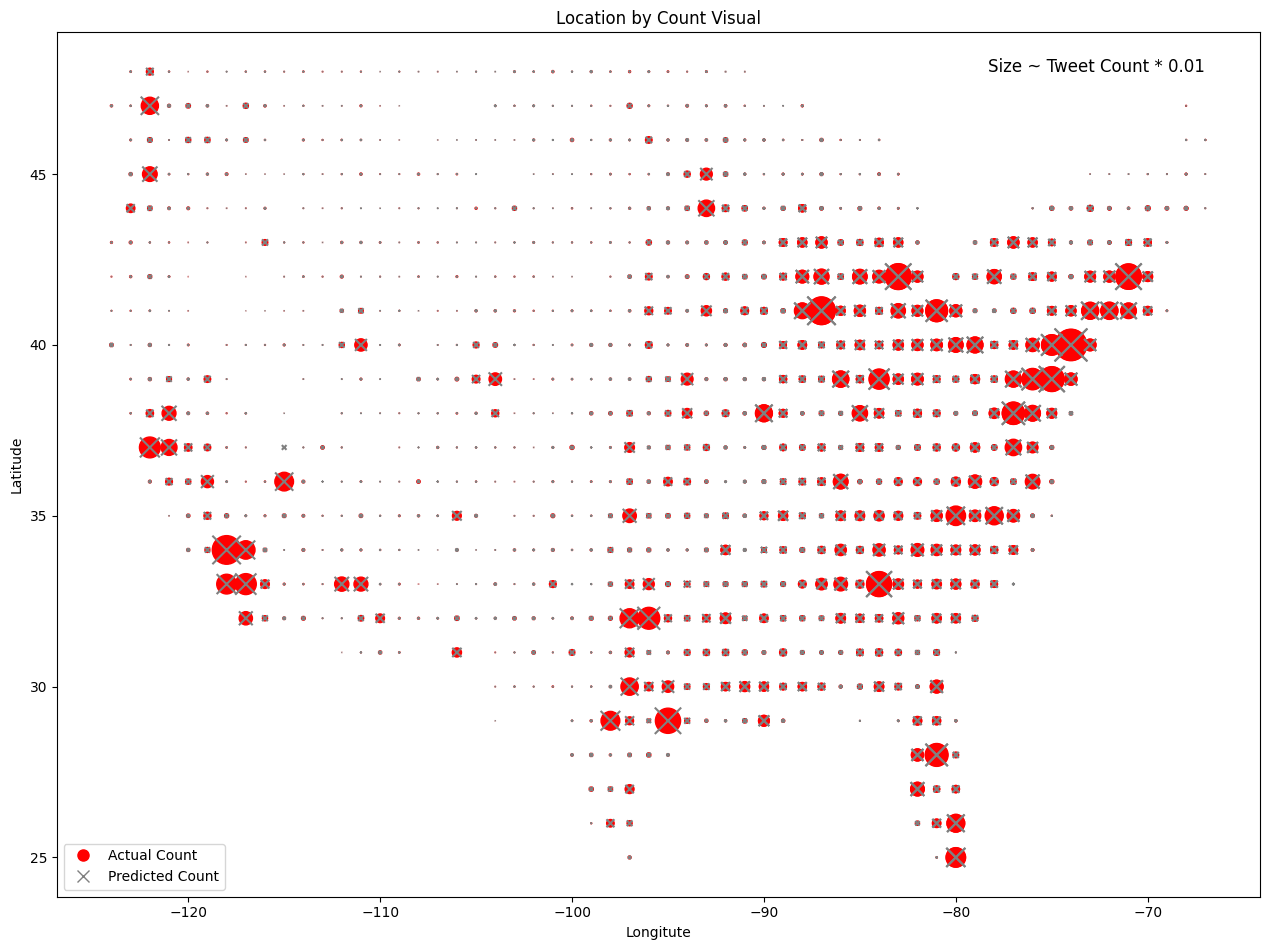

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12.8, 9.6))

ax.scatter(X_test["long"],X_test["lat"],s = twitter_aggregate["Tweet Count"][len(y_train):]*0.01, color="Red")

ax.scatter(X_test["long"],X_test["lat"],s = y_pred*0.01, marker = "x" ,color="Gray")

ax.set_xlabel("Longitute")
ax.set_ylabel("Latitude")
ax.set_title("Location by Count Visual")

legend_handles = [plt.Line2D([], [], marker="o", color="Red", linestyle="None", markersize=8, label="Actual Count"),
                  plt.Line2D([], [], marker="x", color="Gray", linestyle="None", markersize=8, label="Predicted Count")]

ax.legend(handles=legend_handles)

ax.text(X_test["long"].max(), X_test["lat"].max(), "Size ~ Tweet Count * 0.01", fontsize=12, color="black", ha="right")

plt.tight_layout()
plt.show()